In [1]:
import os
import getpass
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from dotenv import load_dotenv

In [2]:
load_dotenv()
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [3]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

In [4]:
llm = ChatOpenAI(model="gpt-4o-mini")


itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

In [6]:
def input_city(state: PlannerState) -> PlannerState:
    print("Please enter the city you want to visit for your day trip:")
    user_message = input("Your input: ")
    return {
        **state,
        "city": user_message,
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

def input_interests(state: PlannerState) -> PlannerState:
    print(f"Please enter your interests for the trip to {state['city']} (comma-separated):")
    user_message = input("Your input: ")
    return {
        **state,
        "interests": [interest.strip() for interest in user_message.split(',')],
        "messages": state['messages'] + [HumanMessage(content=user_message)],
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    print(f"Creating an itinerary for {state['city']} based on interests: {', '.join(state['interests'])}...")
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    print("\nFinal Itinerary:")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary": response.content,
    }

In [7]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

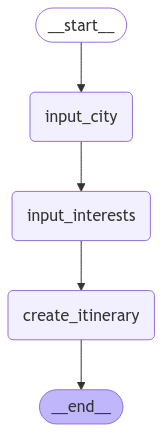

In [8]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [9]:
def run_travel_planner(user_request: str):
    print(f"Initial Request: {user_request}\n")
    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "interests": [],
        "itinerary": "",
    }
    
    for output in app.stream(state):
        pass  # The nodes themselves now handle all printing

In [10]:
user_request = "I want to plan a day trip."
run_travel_planner(user_request)

Initial Request: I want to plan a day trip.

Please enter the city you want to visit for your day trip:
Please enter your interests for the trip to Tulum (comma-separated):
Creating an itinerary for Tulum based on interests: beaches...

Final Itinerary:
Here’s a suggested itinerary for a day trip focused on enjoying the beautiful beaches of Tulum:

### Tulum Beach Day Itinerary

**Morning:**
- **8:00 AM – Sunrise at Playa Paraiso**
  - Arrive early to watch the sunrise over the crystal-clear waters.
  - Enjoy a peaceful morning stroll along the beach.

- **9:00 AM – Breakfast at Manglar Pizzeria**
  - Savor a delicious breakfast with ocean views.
  - Try their fresh fruit platters or traditional Mexican breakfast.

**Late Morning:**
- **10:30 AM – Visit Tulum Ruins**
  - Take a short trip to explore the iconic Tulum Ruins (10-minute drive).
  - Enjoy the stunning views of the coast from the cliffside.

**Lunch:**
- **12:00 PM – Casual lunch at Sale e Pepe**
  - Head back to Tulum beach